# Neural Networks I: MNIST in 17 Lines
### Implemented in Python with Keras

<i>Patrick White</i></br>
<i>Jan 04, 2025</i>

<img src="img/nn1.png" style="height: 400px; width:auto;">

# Outline

- Introduction
- The MNIST Handwritten Digits Dataset
- Preparing the Data
- Model Definition
- Training
- Plotting Results
- Making Predictions
- The Strictly Necessary Lines of Code
- What’s Next?

# Introduction

Modern libraries like Keras make it very easy to build neural networks, regardless of whether you completely understand what is going on under the hood. While I will devote the next article to the inner workings, this first one will demonstrate that we can train a network to recognize handwritten digits using less than 20 lines of Python. There will be additional code along the way to preview the data, etc., but a code cell at the bottom comprises only the lines strictly necessary.

A neural network is of course a computational model consisting of layers of interconnected nodes called neurons, where each node processes input data by applying a weighted sum and activation function to produce an output. They typically include an input layer, one or more hidden layers, and an output layer, and learn to recognize patterns in data by adjusting connection weights and biases, using algorithms like backpropagation and gradient descent.

# The MNIST Handwritten Digits Dataset

Interestingly, even the simple feedforward network (FFN) we’ll be using can handle image data (perhaps it will be more impressive when built from scratch next article); we do not need to rely on fancy architectures like the convolutional neural network (CNN). The parameters, i.e., weights and biases, create a representation of the relationships among pixels robust enough for the model to make soft (distributed) predictions about the image class label.

The MNIST (handwritten digits) dataset is a cliche, but will make for clear demonstration. We can import it directly from Keras.

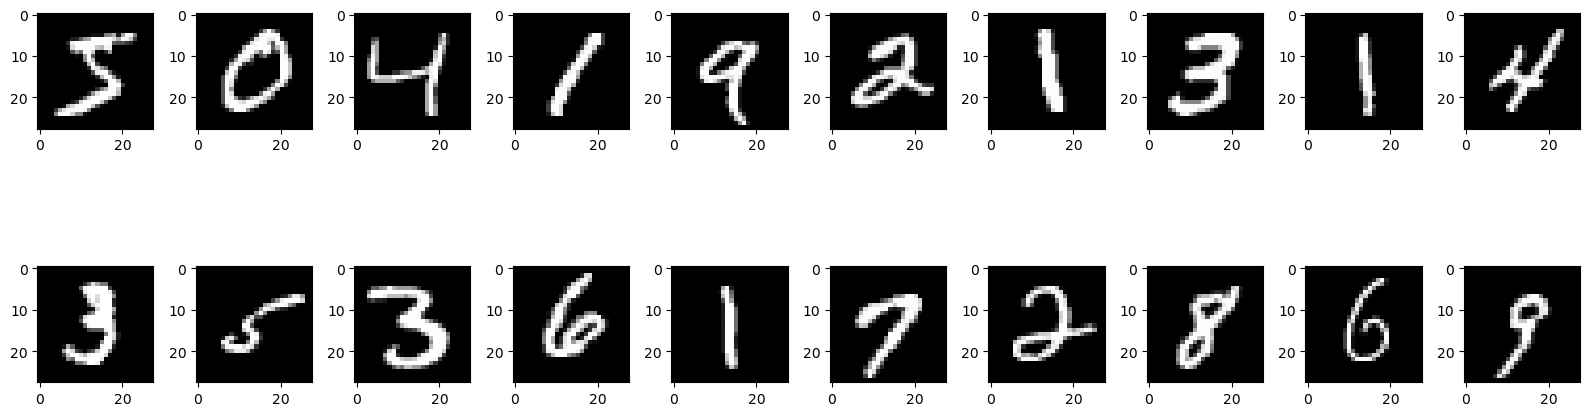

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

X, y = mnist.load_data()

fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(X[0][i], cmap='gray');
    
plt.tight_layout()

# Prepare Data

We load the data into a training set and test set, for both X and y.

The X values are then flattened from a 28x28 pixel array to a one-dimensional array of 784 elements, as this matches the expected format of input to the network.

The pixel values of black and white images range from 0 to 255, and scaling them is a good practice, so we will divide each value by 255.

In [2]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()
X_train_reshaped = X_train.reshape((X_train.shape[0], 28 * 28 * 1)).astype("float32") / 255.0
X_test_reshaped = X_test.reshape((X_test.shape[0], 28 * 28 * 1)).astype("float32") / 255.0

Next, we transform the y values from a list of labels into a one-hot encoded array, as is expected for multi-class classification with a Keras model.

In [3]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [5]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

# Model Definition

Next, we'll start creating and stacking layers. This involves importing the Sequential class (network) and the Dense class (layer) from Keras. The below has 3 layers including the output layer, with 256, 128, and 10 nodes (neurons) respectively. The input shape must match our data, which is 784x1, and the output shape should match the number of classes to choose from, which is 10. The 'activation' functions are discussed in the next article.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Dense(256, input_shape=(784,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

We can use <code>model.summary()</code> to have Keras print a summary of the architecture.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

# Training

Certain training hyperparameters will need to be set, so we’ll introduce a few terms/concepts:

- Stochastic Gradient Descent (SGD): Gradient descent is the method used to adjust weights based on error, and with the full training set, it is called batch gradient descent. With only a sample of data at a time, as is done more often for computational efficiency, it is called stochastic gradient descent, or mini-batch gradient descent. This is the method we will select for training.

- Batch Size: When performing SGD, this is the size of the samples from the data.

- Learning Rate: Updates to weights multiply the gradient of cost/loss against a step size factor known as the learning rate. A value like 0.1 or 0.01 is typical.

- Epoch: Refers to one full pass through the data. We must set the number of training epochs, though we can also set early stopping to occur, if performance stops improving during training.

In [8]:
from numpy.random import seed
from keras.optimizers import SGD

seed(123)
sgd = SGD(learning_rate = 0.01)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=50, batch_size=128)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1470 - loss: 2.3099 - val_accuracy: 0.3155 - val_loss: 2.2364
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3444 - loss: 2.2190 - val_accuracy: 0.5237 - val_loss: 2.1528
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5102 - loss: 2.1316 - val_accuracy: 0.5935 - val_loss: 2.0378
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5584 - loss: 2.0075 - val_accuracy: 0.6131 - val_loss: 1.8733
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5906 - loss: 1.8343 - val_accuracy: 0.6723 - val_loss: 1.6664
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6493 - loss: 1.6306 - val_accuracy: 0.6911 - val_loss: 1.4518
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6965 - loss: 1.4215 - val_accuracy: 0.7349 - val_loss: 1.2609
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7374 - loss: 1.2386 - val_accuracy: 0.

## Plotting Results

### Loss

Below plots the loss of the training set and validation set at each epoch during training. We see that the network avoids overfitting, which is when the loss of the training set continues to decline without a corresponding effect on the loss of the validation set.

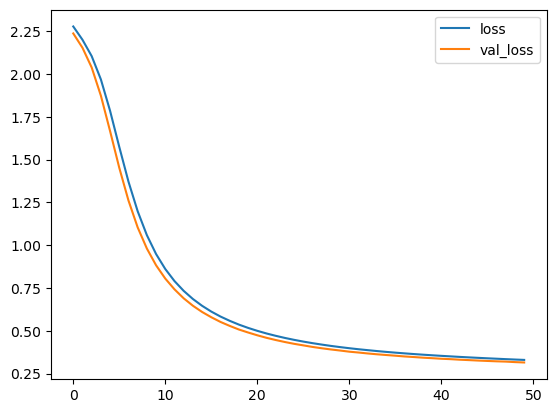

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Accuracy

However, in plotting the accuracy, we see that it plateaus around 90%, and state of the art models on this dataset are capable of doing much better.

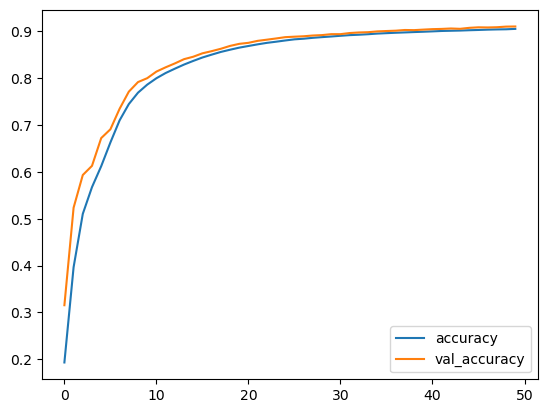

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Making Predictions

With the model trained, we can make predictions using the <code>model.predict</code> method. We'll use the first instance of the test set as an example.

In [11]:
test_pred = model.predict(X_test_reshaped[0:1])
test_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[2.6546884e-04, 1.7361374e-06, 2.3686346e-04, 1.8535842e-03,
        6.5393547e-06, 1.2480875e-04, 1.8131367e-07, 9.9351281e-01,
        3.0429406e-05, 3.9675962e-03]], dtype=float32)

It outputs an array of 10 probability-like values, one for each class label, which are between 0 and 1, and sum to 1. Below is a bar-plot of these values.

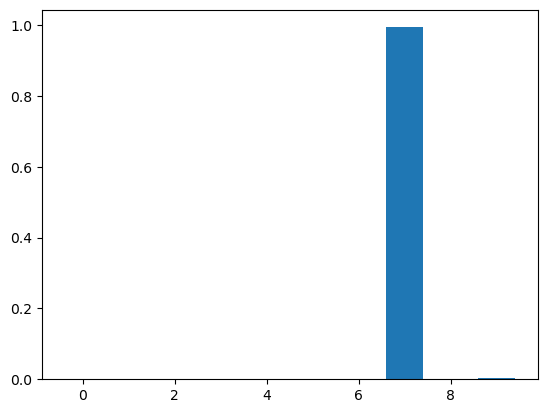

In [12]:
plt.bar(range(0,10),test_pred[0]);

The plot makes it clear which class label is favored as the prediction. We can also use the <code>argmax()</code> function to extract the index associated with this value.

In [13]:
test_pred[0].argmax()

7

Taking the argmax of <code>y_test[0]</code> to compare, we see that the prediction is correct.

In [14]:
y_test[0].argmax()

7

And we can further verify by checking the image.

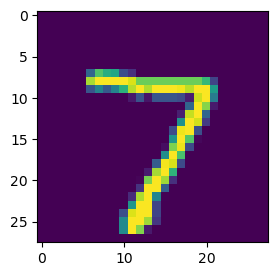

In [15]:
plt.figure(figsize = (3,3))
plt.imshow(X_test[0]);

## The Strictly Necessary Lines of Code

As promised, below are the necessary 17 lines of code to import the libraries and data, define the network, and train it to make predictions.

In [ ]:
from keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

((X_train, y_train), (X_test, y_test)) = mnist.load_data()
X_train_reshaped = X_train.reshape((X_train.shape[0], 28 * 28 * 1)).astype("float32") / 255.0
X_test_reshaped = X_test.reshape((X_test.shape[0], 28 * 28 * 1)).astype("float32") / 255.0

lb = LabelBinarizer()
y_train, y_test = lb.fit_transform(y_train), lb.transform(y_test)

model = Sequential()
model.add(Dense(256, input_shape=(784,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

sgd = SGD(learning_rate = 0.01)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=50, batch_size=128)

# What’s Next?

Next article gets much more in-depth, and goes to the other extreme of complexity, by building a neural network from scratch. The article following that one gets into hyperparameter tuning.

# References

- Brownlee, J. (2021). Better Deep Learning (1st ed.). Machine Learning Mastery. https://machinelearningmastery.com/better-deep-learning/

- Nielsen, M. (2018). Neural Networks and Deep Learning. 
http://neuralnetworksanddeeplearning.com/index.html

- Sanderson, G. (2017). Neural Networks. 3Blue1Brown. https://www.3blue1brown.com/topics/neural-networks

- Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Deep Learning. MIT Press, 2016. https://www.deeplearningbook.org/

- Cohen, M. X. (2024). A deep understanding of deep learning [Online Video]. Udemy. https://www.udemy.com/course/deeplearning_x